In [1]:
#Data Handling
import pandas as pd
import numpy as np
import tifffile as tiff
from math import pi
import os

#Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm

# Data Manipulation
from scipy.stats import gaussian_kde
from scipy.signal import argrelextrema
from scipy.signal import argrelmax
from scipy.signal import find_peaks

In [4]:
dict_of_mutants = {
    'jRGECO1a':['01','02','03','04'],
    'S319D': ['05','06','07','08'],
    'D111V': ['09','10','11','12'],
    'L415V': ['13','14','15','16'],
    'E357A': ['17','18','19','20'],
    'R393V': ['21','22','23','24'],
    'E357C': ['25','26','27','28'],
    'M354A': ['29','30','31','32'],
    'L415A': ['33','34','35','36'],
    'R393L': ['37','38','39','40'],

    #'A46L':['01','02','03','04'],
    #'A46F': ['05','07','08'],
    #'D111G': ['09','10','11','12'],
    #'L56A': ['13','14','15','16'],
    #'L56G': ['17','18','19','20'],
    #'K45D': ['21','22','23','24'],
    #'R135V': ['25','26','27','28'],
    #'R135K': ['29','31','32'],
    #'K42I': ['33','34','35','36'],
    #'L42L': ['37','38','39','40'],
    #'I112L': ['41','42','43','44'],
    #'K42V': ['45','46','47','48'],
    #'R135M': ['49','50','51','52'],
    #'D111N': ['55','56','57','58'],

    'M354A_R393L': ['41','42','43','44'],
    'R393V_L415A': ['45','46','47','48'],
    'D111V_L415V': ['49','50','51','52'],
    'E357A_L415V': ['54','55','56'],
    'R393V_L415V': ['57','58','59','60'],
    'E357C_L415V': ['61','62','63','64'],
    'M354A_L415V': ['65','66','67','68'],
    'E357A_R393V': ['69','70','71','72'],
    'M354A_R393V': ['74','75','76'],
    'F275L_E357A_R393V': ['77','78','79','80'],
    'P288H_L321A': ['81','82','83','84']
}

variant_color_map = {
'jRGECO1a': "#1F78B4",'S319D': "#3684BC",'D111V': "#6BAED6",  'L415V': "#8AC6E2",  'E357A': "#A2D4EB",
'R393V': "#B3DAEC",  'E357C': "#C9E3F3",'M354A': "#F2F8FC", 'L415A': "#FFE79B",  'R393L': "#FFD25A", 

'M354A_R393L': "#FDD991",'R393V_L415A': "#FDD49E",  'D111V_L415V': "#FDC18A",'E357A_L415V': "#FDBB84",  
'R393V_L415V': "#FC9B6B",  'E357C_L415V': "#FA815C",'M354A_L415V': "#FC8D59", 'E357A_R393V': "#F2451D",  
'M354A_R393V': "#EF6548",'F275L_E357A_R393V': "#D7301F",'P288H_L321A': "#B30000"
}

"""
variant_color_map = {
    'jRGECO1a': "#4169E1",'S319D': "#5A78E6",'D111V': "#7888EC",'L415V': "#9589E7",'E357A': "#B193E5",
    'R393V': "#C69DDC",'E357C': "#D5A4D4",'M354A': "#E0A9C7",'L415A': "#E8B3C0",'R393L': "#F1BAC0",
    'A46L': "#F9D3BE",'A46F': "#F6A79E",'D111G': "#F18B7F",'L56A': "#EC705F",'L56G': "#E6573C",'K45D': "#DD4733",
    'R135V': "#EC6E47",'R135K': "#F98D36",'K42I': "#FFAA3B",'L42L': "#FFD452",'I112L': "#FFF07C",'K42V': "#DCE56B",
    'R135M': "#B7D95B",'D111N': "#95C946"
}
"""
path_1 = "E:/Synology/Imaging/2025_04_04_jRGECO1a_Double_Mutations/2025-04-04_CP_segementation_and_analysis/analysis/"
last_bit = '_delta_f_over_f_analysis.csv'
output_folder = "E:/Synology/Imaging/2025_04_04_jRGECO1a_Double_Mutations/2025-04-04_CP_segementation_and_analysis/results"
os.makedirs(output_folder, exist_ok=True)

In [5]:
list_of_mutants = []
delta_f_output_df = pd.DataFrame()

for label in dict_of_mutants:
  list_of_mutants.append(label)

for mutant in dict_of_mutants.keys():
    list_ = [] 
    for video_number in dict_of_mutants[mutant]:
        data = list(pd.read_csv(path_1+video_number+last_bit,index_col = 0)['max ∆F/F (%)'].values)
        
        # Calculate IQR
        q1 = np.percentile(data, 25)
        q3 = np.percentile(data, 75)
        iqr = q3 - q1

        # Filter data within IQR
        inner_iqr_values = [x for x in data if q1 <= x <= q3]
        list_ = list_ + inner_iqr_values

    delta_f_output_df = pd.concat([delta_f_output_df,pd.DataFrame({'delta_f':list_, 'variant':[mutant for e in list_]})])

delta_f_output_df

,delta_f,variant
0,256.406075,jRGECO1a
1,243.088521,jRGECO1a
2,241.406504,jRGECO1a
3,241.003664,jRGECO1a
4,237.897296,jRGECO1a
...,...,...
106,236.341483,P288H_L321A
107,152.916631,P288H_L321A
108,99.791566,P288H_L321A
109,64.289938,P288H_L321A


In [6]:
means = []
std_devs = []
colors = []

variants = delta_f_output_df['variant'].unique()

for i, variant in enumerate(variants):
    data_points = delta_f_output_df[delta_f_output_df['variant'] == variant]['delta_f'].values
    mean = np.mean(data_points)
    std_dev = np.std(data_points)
    means.append(mean)
    std_devs.append(std_dev)
    colors.append(variant_color_map.get(variant, '#000000'))

# If you want to show the data as descent order use these codes
"""
sorted_indices = np.argsort(means)[::-1]
sorted_variants = [variants[i] for i in sorted_indices]
sorted_means = [means[i] for i in sorted_indices]
sorted_std_devs = [std_devs[i] for i in sorted_indices]
sorted_colors = [colors[i] for i in sorted_indices]
"""

# Use the original order
sorted_variants = variants
sorted_means = means
sorted_std_devs = std_devs
sorted_colors = colors

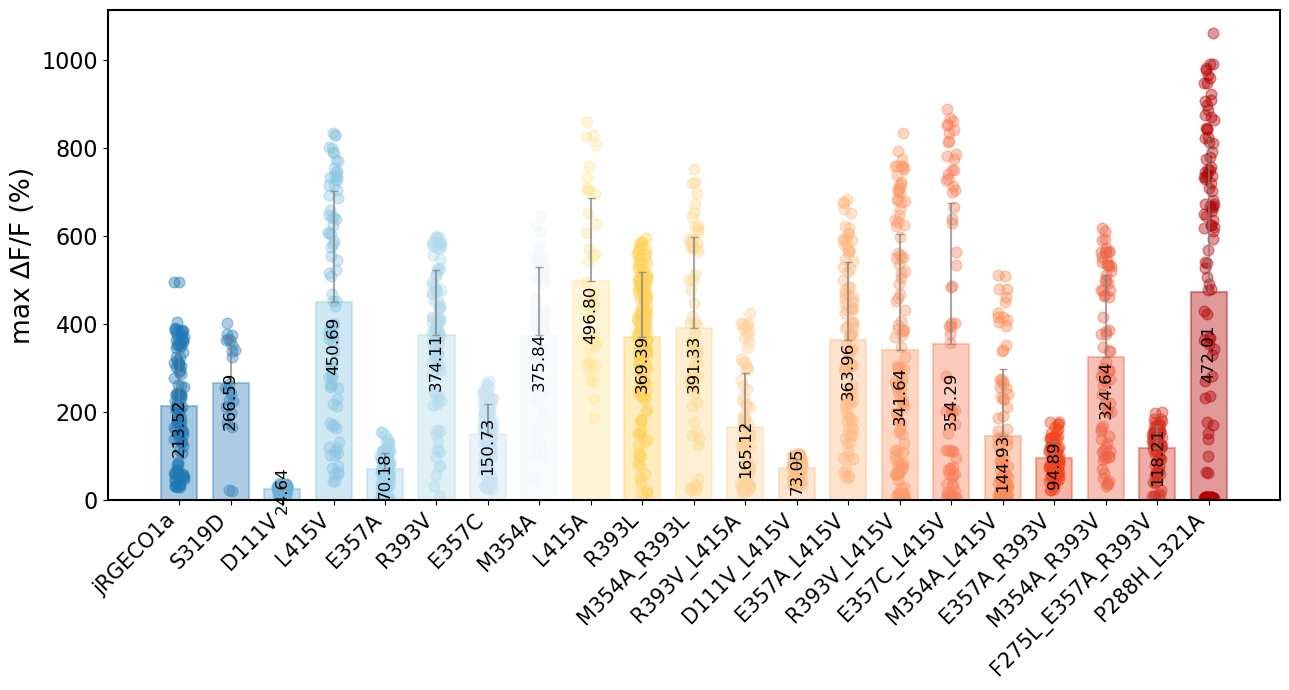

'E:/Synology/Imaging/2025_04_04_jRGECO1a_Double_Mutations/2025-04-04_CP_segementation_and_analysis/results\\max F-F (percent).pdf'

In [7]:
plt.figure(figsize=(13, 7))

for i, (variant, mean, std_dev, color) in enumerate(zip(sorted_variants, sorted_means, sorted_std_devs, sorted_colors)):
    data_points = delta_f_output_df[delta_f_output_df['variant'] == variant]['delta_f'].values
    x_positions = np.full_like(data_points, i, dtype=float) + (np.random.rand(len(data_points)) - 0.5) * 0.2
    
    # Scatter Plot
    plt.scatter(x_positions, data_points, color=color, label=variant, alpha=0.4, s=60)
    
    # Bar Plot
    plt.bar(i, mean, color=color, edgecolor=color, linewidth=1.5, alpha=0.4, width=0.7)
    
    # Mean Values
    plt.text(i, mean - std_dev * 0.4, f"{mean:.2f}", ha='center', va='center', fontsize=12, color='black', rotation=90)

    # Error Bars (only show positive standard deviation)
    upper_error = std_dev if std_dev > 0 else 0
    lower_error = 0

    if upper_error > 0:
        plt.errorbar(
            i, mean,
            yerr=[[lower_error], [upper_error]],
            fmt='', color='grey', alpha=0.7, capsize=3
        )

# X-Y axis
plt.ylabel("max ∆F/F (%)", fontsize=19)
plt.yticks(fontsize=16)
plt.xticks(
    ticks=np.arange(len(sorted_variants)),
    labels=sorted_variants,
    fontsize=15, rotation=45,
    ha='right', va='top'
)

# Outer box
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(1.5)


plt.tight_layout()
output_file = os.path.join(output_folder, "max F-F (percent).pdf")
plt.savefig(output_file, format='pdf')
plt.show()
output_file

In [8]:
list_of_mutants = []
baseline_output_df = pd.DataFrame()

for label in dict_of_mutants:
  list_of_mutants.append(label)

for mutant in dict_of_mutants.keys():
    list_ = [] 
    for video_number in dict_of_mutants[mutant]:
        data = list(pd.read_csv(path_1+video_number+last_bit,index_col = 0)['Baseline'].values)
        
        # Calculate IQR
        q1 = np.percentile(data, 25)
        q3 = np.percentile(data, 75)
        iqr = q3 - q1

        # Filter data within IQR
        inner_iqr_values = [x for x in data if q1 <= x <= 1100]
        list_ = list_ + inner_iqr_values

    baseline_output_df = pd.concat([baseline_output_df,pd.DataFrame({'Baseline':list_, 'variant':[mutant for e in list_]})])

baseline_output_df

,Baseline,variant
0,288.9035,jRGECO1a
1,328.9220,jRGECO1a
2,361.7930,jRGECO1a
3,274.0925,jRGECO1a
4,396.2910,jRGECO1a
...,...,...
160,67.7215,P288H_L321A
161,66.6045,P288H_L321A
162,63.0350,P288H_L321A
163,132.5885,P288H_L321A


In [9]:
means = []
std_devs = []
colors = []

variants = baseline_output_df['variant'].unique()

for i, variant in enumerate(variants):
    data_points = baseline_output_df[baseline_output_df['variant'] == variant]['Baseline'].values
    mean = np.mean(data_points)
    std_dev = np.std(data_points)
    means.append(mean)
    std_devs.append(std_dev)
    colors.append(variant_color_map.get(variant, '#000000'))


sorted_indices = np.argsort(means)[::-1]
sorted_variants = [variants[i] for i in sorted_indices]
sorted_means = [means[i] for i in sorted_indices]
sorted_std_devs = [std_devs[i] for i in sorted_indices]
sorted_colors = [colors[i] for i in sorted_indices]

# If you want to show the data as descent order use these codes
"""
sorted_indices = np.argsort(means)[::-1]
sorted_variants = [variants[i] for i in sorted_indices]
sorted_means = [means[i] for i in sorted_indices]
sorted_std_devs = [std_devs[i] for i in sorted_indices]
sorted_colors = [colors[i] for i in sorted_indices]
"""

# Use the original order
sorted_variants = variants
sorted_means = means
sorted_std_devs = std_devs
sorted_colors = colors

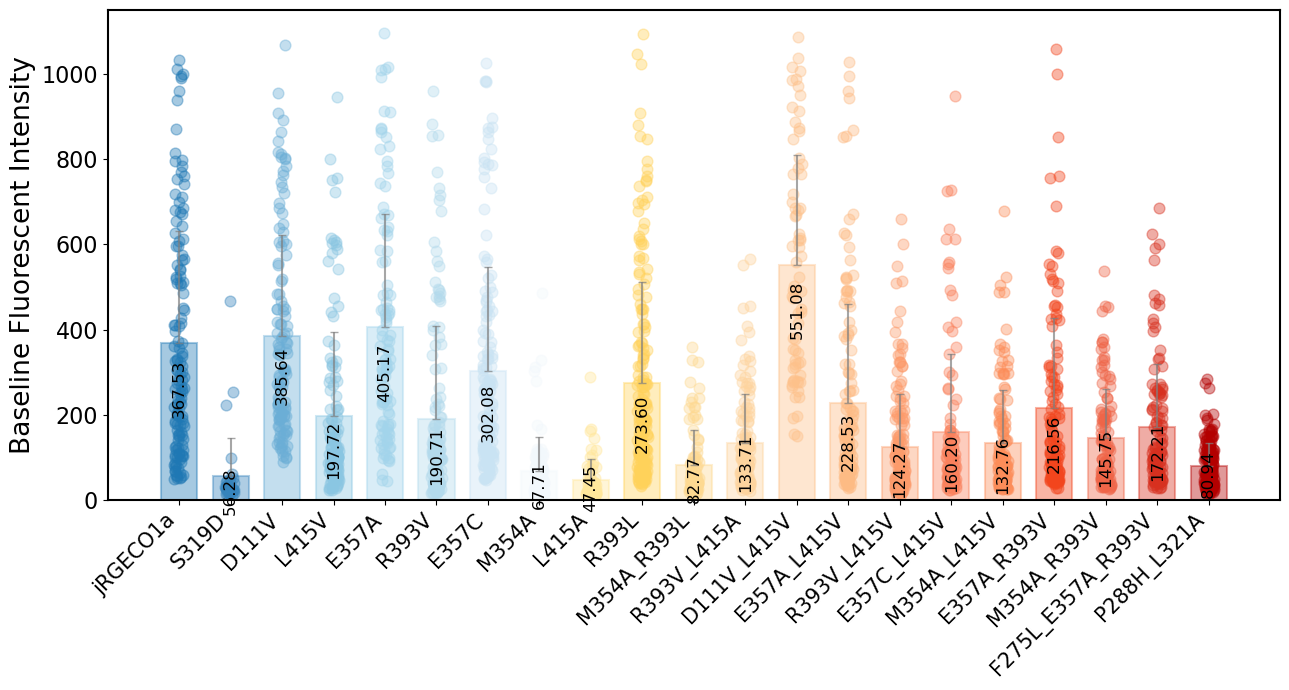

'E:/Synology/Imaging/2025_04_04_jRGECO1a_Double_Mutations/2025-04-04_CP_segementation_and_analysis/results\\Baseline_Fluorescene_Intensity.pdf'

In [10]:
plt.figure(figsize=(13, 7))

for i, (variant, mean, std_dev, color) in enumerate(zip(sorted_variants, sorted_means, sorted_std_devs, sorted_colors)):
    data_points = baseline_output_df[baseline_output_df['variant'] == variant]['Baseline'].values
    x_positions = np.full_like(data_points, i, dtype=float) + (np.random.rand(len(data_points)) - 0.5) * 0.2
    
    # Scatter Plot
    plt.scatter(x_positions, data_points, color=color, label=variant, alpha=0.4, s=60)
    
    # Bar Plot
    plt.bar(i, mean, color=color, edgecolor=color, linewidth=1.5, alpha=0.4, width=0.7)
    
    # Mean Values
    plt.text(i, mean - std_dev * 0.4, f"{mean:.2f}", ha='center', va='center', fontsize=12, color='black', rotation=90)

    # Error Bars (only show positive standard deviation)
    upper_error = std_dev if std_dev > 0 else 0
    lower_error = 0

    if upper_error > 0:
        plt.errorbar(
            i, mean,
            yerr=[[lower_error], [upper_error]],
            fmt='', color='grey', alpha=0.7, capsize=3
        )

# X-Y axis
plt.ylabel("Baseline Fluorescent Intensity", fontsize=19)
plt.yticks(fontsize=16)
plt.xticks(
    ticks=np.arange(len(sorted_variants)),
    labels=sorted_variants,
    fontsize=15, rotation=45,
    ha='right', va='top'
)

# Outer box
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(1.5)


plt.tight_layout()
output_file = os.path.join(output_folder, "Baseline_Fluorescene_Intensity.pdf")
plt.savefig(output_file, format='pdf')
plt.show()
output_file

In [11]:
last_bit = '_delta_f_over_f_raw.csv'
list_of_mutants = []
kinetic_df = pd.DataFrame()

for label in dict_of_mutants:
    list_of_mutants.append(label)

for mutant in dict_of_mutants.keys():
    mutant_info = []
    list_ = []
    
    for video_number in dict_of_mutants[mutant]:
        print(video_number)
        data = pd.read_csv(path_1 + video_number + last_bit, index_col=0)
        video_list = []
        
        for col in data.columns:
            if data[col].max() > 1:
                delta_list = []
                index = data[col].idxmax()
                index_pos = data.index.get_loc(index)
                
                # Ensure index_pos is a scalar value
                if isinstance(index_pos, (np.ndarray, list)):
                    index_pos = index_pos[0]  # Take the first value as index_pos

                if index_pos > 30 and index_pos < 80:
                    for I in range(10):
                        if (index_pos + I + 1) < len(data):
                            delta = abs((data[col].iloc[index_pos + I + 1]) / data[col].max() - (data[col].iloc[index_pos + I]) / data[col].max())
                            delta_list.append(delta)

                if len(delta_list) > 0:
                    video_list.append(sum(delta_list) * 100 / 5)
                    mutant_info.append(sum(delta_list) * 100 / 5)

        print(video_list)

        q1 = np.percentile(video_list, 25)
        q3 = np.percentile(video_list, 75)
        iqr = q3 - q1
        inner_iqr_values = [x for x in video_list if q1 <= x <= 50]
        list_ += inner_iqr_values

    kinetic_df = pd.concat([kinetic_df, pd.DataFrame({'kinetics': list_, 'variant': [mutant] * len(list_)})])



01
[np.float64(0.5315305463893849), np.float64(3.6514623210531445), np.float64(0.42654768745624905), np.float64(0.539260707274114), np.float64(57.052134735035814), np.float64(2.0613017462449568), np.float64(1.5271659324522746), np.float64(26.201974837737254), np.float64(1.5465698345376055), np.float64(4.104727746490078), np.float64(2.9069989125444784), np.float64(0.8332103891359521), np.float64(0.6868215746882078), np.float64(4.460845003992948), np.float64(2.9294804477337144), np.float64(0.46166640292784944), np.float64(1.2144387319302852), np.float64(14.024879400156237), np.float64(5.21440033087355), np.float64(1.7534657589794178), np.float64(3.8163048011351046), np.float64(1.7931344882561937), np.float64(4.550953360557588), np.float64(3.3526037365237427), np.float64(4.2405257134259955), np.float64(0.5678082948879815), np.float64(2.5207947117595397), np.float64(0.6025388685919864), np.float64(44.349982288346), np.float64(0.48301353321455576)]
02
[np.float64(1.8284792363410207), np.flo

In [168]:
means = []
std_devs = []
colors = []

variants = kinetic_df['variant'].unique()

for i, variant in enumerate(variants):
    data_points = kinetic_df[kinetic_df['variant'] == variant]['kinetics'].values
    mean = np.mean(data_points)
    std_dev = np.std(data_points)
    means.append(mean)
    std_devs.append(std_dev)
    colors.append(variant_color_map.get(variant, '#000000'))


# If you want to show the data as descent order use these codes
"""
sorted_indices = np.argsort(means)[::-1]
sorted_variants = [variants[i] for i in sorted_indices]
sorted_means = [means[i] for i in sorted_indices]
sorted_std_devs = [std_devs[i] for i in sorted_indices]
sorted_colors = [colors[i] for i in sorted_indices]
"""

# Use the original order
sorted_variants = variants
sorted_means = means
sorted_std_devs = std_devs
sorted_colors = colors

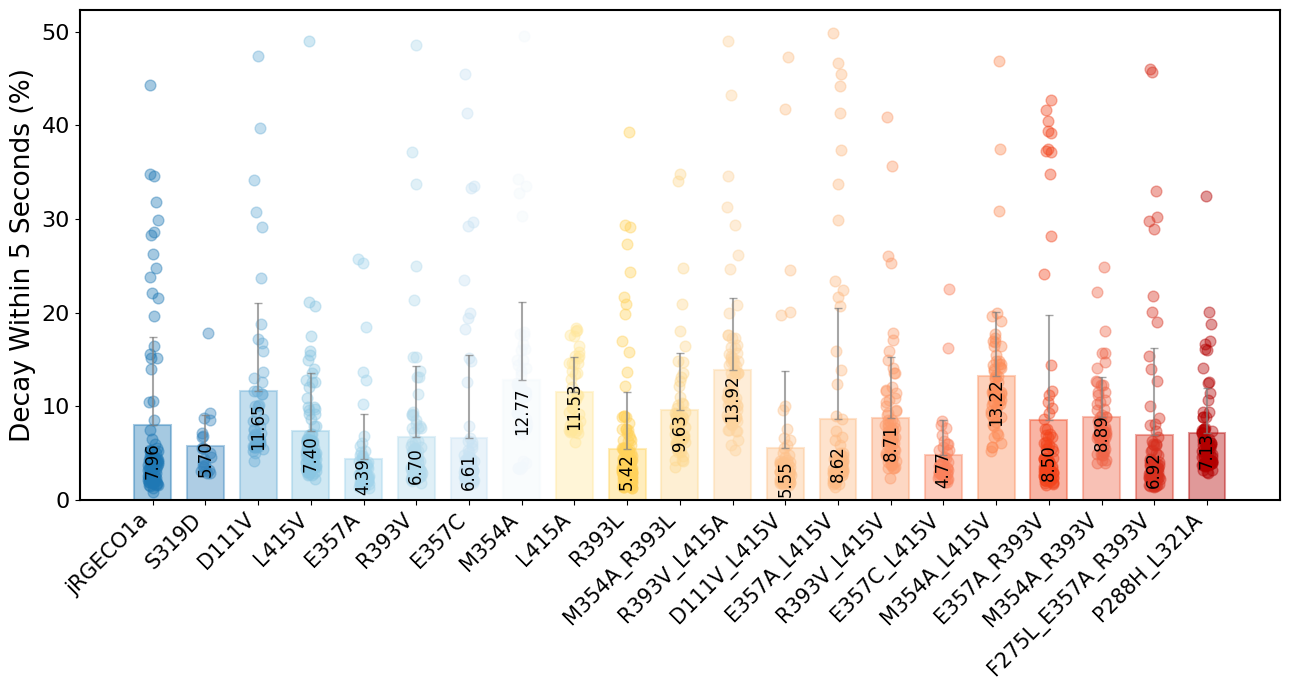

'E:/Synology_Backup/Imaging/2025_04_04_jRGECO1a_Double_Mutations/2025-04-04_CP_segementation_and_analysis/results\\Decay_Within_5_Seconds.pdf'

In [169]:
plt.figure(figsize=(13, 7))

for i, (variant, mean, std_dev, color) in enumerate(zip(sorted_variants, sorted_means, sorted_std_devs, sorted_colors)):
    data_points = kinetic_df[kinetic_df['variant'] == variant]['kinetics'].values
    x_positions = np.full_like(data_points, i, dtype=float) + (np.random.rand(len(data_points)) - 0.5) * 0.2
    
    # Scatter Plot
    plt.scatter(x_positions, data_points, color=color, label=variant, alpha=0.4, s=60)
    
    # Bar Plot
    plt.bar(i, mean, color=color, edgecolor=color, linewidth=1.5, alpha=0.4, width=0.7)
    
    # Mean Values
    plt.text(i, mean - std_dev * 0.4, f"{mean:.2f}", ha='center', va='center', fontsize=12, color='black', rotation=90)

    # Error Bars (only show positive standard deviation)
    upper_error = std_dev if std_dev > 0 else 0
    lower_error = 0

    if upper_error > 0:
        plt.errorbar(
            i, mean,
            yerr=[[lower_error], [upper_error]],
            fmt='', color='grey', alpha=0.7, capsize=3
        )

# X-Y axis
plt.ylabel("Decay Within 5 Seconds (%)", fontsize=19)
plt.yticks(fontsize=16)
plt.xticks(
    ticks=np.arange(len(sorted_variants)),
    labels=sorted_variants,
    fontsize=15, rotation=45,
    ha='right', va='top'
)

# Outer box
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(1.5)


plt.tight_layout()
output_file = os.path.join(output_folder, "Decay_Within_5_Seconds.pdf")
plt.savefig(output_file, format='pdf')
plt.show()
output_file

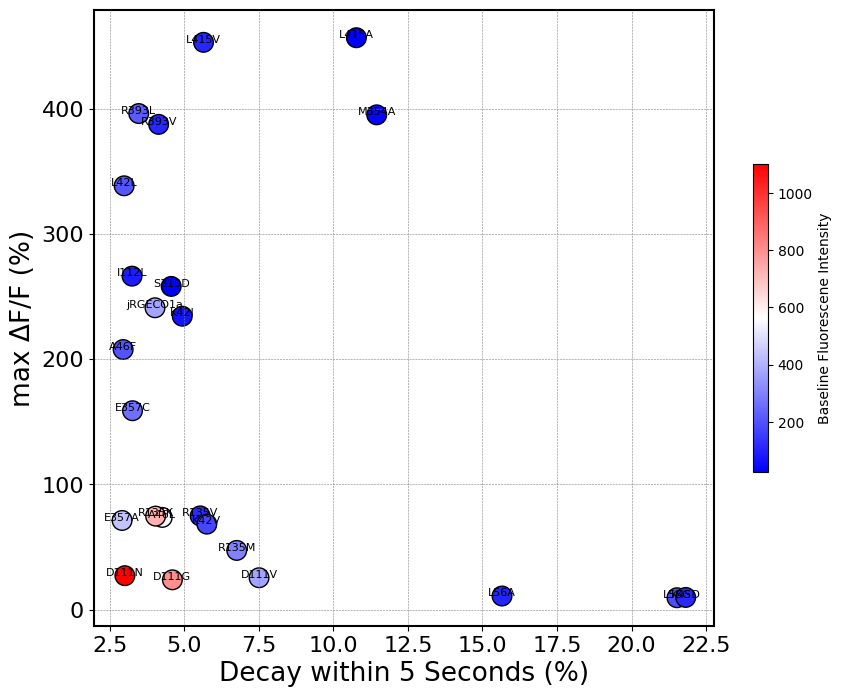

'E:/Synology_Backup/Imaging/2025_04_04_jRGECO1a_Single_Mutations/2025-04-05_CP_segementation_and_analysis/results\\Hotplot.pdf'

In [154]:
kinetic_output_list = []
delta_f_output_list = []
baseline_output_list = []
mutant_output_list = []

for variant in kinetic_df['variant'].unique():
    variant_kinetic = kinetic_df[kinetic_df['variant'] == variant]['kinetics']
    variant_delta_f = delta_f_output_df[delta_f_output_df['variant'] == variant]['delta_f']
    variant_baseline = baseline_output_df[baseline_output_df['variant'] == variant]['Baseline']
    
    u = np.median(variant_kinetic)  # x-position of the center
    v = np.median(variant_delta_f)  # y-position of the center
    z = np.median(variant_baseline)

    kinetic_output_list.append(u)
    delta_f_output_list.append(v)
    baseline_output_list.append(z)
    mutant_output_list.append(variant)

df = pd.DataFrame({'kinetics': kinetic_output_list,
                   'delta_f': delta_f_output_list,
                   'baseline': baseline_output_list,
                   'mutant': mutant_output_list})

variant = 'jRGECO1a'

variant_kinetic = kinetic_df[kinetic_df['variant'] == variant]['kinetics']
variant_delta_f = delta_f_output_df[delta_f_output_df['variant'] == variant]['delta_f']
variant_baseline = baseline_output_df[baseline_output_df['variant'] == variant]['Baseline']

u = np.median(variant_kinetic)  # x-position of the center
v = np.median(variant_delta_f)  # y-position of the center
z = np.median(variant_baseline)

plt.figure(figsize=(10, 8))

plt.grid(True, which='both', axis='both', linestyle='--', linewidth=0.4, color='gray')

plt.scatter(df.kinetics, df.delta_f, s=200, c=df.baseline, cmap='bwr', edgecolors='black')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Decay within 5 Seconds (%)', fontsize=19)
plt.ylabel('max ΔF/F (%)', fontsize=19)
plt.colorbar(label='Baseline Fluorescene Intensity', shrink=0.5)

ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(1.5)

for row in range(len(df)):
    plt.text(x=df.iloc[row]['kinetics'], y=df.iloc[row]['delta_f'], s=df.iloc[row]['mutant'], fontsize= 8, ha='center')


output_file = os.path.join(output_folder, "Hotplot.pdf")
plt.savefig(output_file, format='pdf')
plt.show()
output_file

In [155]:
base_path = r"E:/Synology_Backup/Imaging/2025_04_04_jRGECO1a_Single_Mutations/"
variants = {}
for mutant, numbers in dict_of_mutants.items():
    file_paths = []
    for number in numbers:
        sample_path = os.path.join(base_path, f"BS50/sample_{number}.tif")
        mask_path = os.path.join(base_path, f"2025-04-04_CP_segementation_and_analysis/mask/{number}_mask.npy")
        file_paths.append((sample_path, mask_path))
    variants[mutant] = file_paths

for mutant, paths in variants.items():
    print(mutant, paths)

jRGECO1a [('E:/Synology_Backup/Imaging/2025_04_04_jRGECO1a_Single_Mutations/BS50/sample_101.tif', 'E:/Synology_Backup/Imaging/2025_04_04_jRGECO1a_Single_Mutations/2025-04-04_CP_segementation_and_analysis/mask/101_mask.npy'), ('E:/Synology_Backup/Imaging/2025_04_04_jRGECO1a_Single_Mutations/BS50/sample_102.tif', 'E:/Synology_Backup/Imaging/2025_04_04_jRGECO1a_Single_Mutations/2025-04-04_CP_segementation_and_analysis/mask/102_mask.npy'), ('E:/Synology_Backup/Imaging/2025_04_04_jRGECO1a_Single_Mutations/BS50/sample_103.tif', 'E:/Synology_Backup/Imaging/2025_04_04_jRGECO1a_Single_Mutations/2025-04-04_CP_segementation_and_analysis/mask/103_mask.npy'), ('E:/Synology_Backup/Imaging/2025_04_04_jRGECO1a_Single_Mutations/BS50/sample_104.tif', 'E:/Synology_Backup/Imaging/2025_04_04_jRGECO1a_Single_Mutations/2025-04-04_CP_segementation_and_analysis/mask/104_mask.npy'), ('E:/Synology_Backup/Imaging/2025_04_04_jRGECO1a_Single_Mutations/BS50/sample_53.tif', 'E:/Synology_Backup/Imaging/2025_04_04_jRGE

In [156]:
results = {}

for variant, files in variants.items():
    all_dff = []
    for tif_file, mask_file in files:
        if not os.path.exists(tif_file) or not os.path.exists(mask_file):
            print(f"File missing for {variant}: {tif_file} or {mask_file}")
            continue

        tif_data = tiff.imread(tif_file)
        mask = np.load(mask_file)

        assert tif_data.ndim == 3
        frames, height, width = tif_data.shape
        roi_ids = np.unique(mask[mask > 0])

        mean_intensities = []
        for frame_idx in range(frames):
            frame = tif_data[frame_idx]
            roi_means = [frame[mask == roi_id].mean() for roi_id in roi_ids]
            mean_intensities.append(np.mean(roi_means))

        mean_intensities = np.array(mean_intensities)

        # Calculate the first 20 frames fluorescene intensity as baseline
        f0 = mean_intensities[:20].mean()
        dff = (mean_intensities - f0) / f0
        all_dff.append(dff)

    all_dff = np.array(all_dff)
    mean_dff = all_dff.mean(axis=0)
    sem_dff = all_dff.std(axis=0) / np.sqrt(all_dff.shape[0])

    results[variant] = {
        "mean_dff": mean_dff,
        "sem_dff": sem_dff,
    }

File missing for jRGECO1a: E:/Synology_Backup/Imaging/2025_04_04_jRGECO1a_Single_Mutations/BS50/sample_101.tif or E:/Synology_Backup/Imaging/2025_04_04_jRGECO1a_Single_Mutations/2025-04-04_CP_segementation_and_analysis/mask/101_mask.npy
File missing for jRGECO1a: E:/Synology_Backup/Imaging/2025_04_04_jRGECO1a_Single_Mutations/BS50/sample_102.tif or E:/Synology_Backup/Imaging/2025_04_04_jRGECO1a_Single_Mutations/2025-04-04_CP_segementation_and_analysis/mask/102_mask.npy
File missing for jRGECO1a: E:/Synology_Backup/Imaging/2025_04_04_jRGECO1a_Single_Mutations/BS50/sample_103.tif or E:/Synology_Backup/Imaging/2025_04_04_jRGECO1a_Single_Mutations/2025-04-04_CP_segementation_and_analysis/mask/103_mask.npy
File missing for jRGECO1a: E:/Synology_Backup/Imaging/2025_04_04_jRGECO1a_Single_Mutations/BS50/sample_104.tif or E:/Synology_Backup/Imaging/2025_04_04_jRGECO1a_Single_Mutations/2025-04-04_CP_segementation_and_analysis/mask/104_mask.npy
File missing for jRGECO1a: E:/Synology_Backup/Imagin

C:\Users\shuyu\AppData\Local\Temp\ipykernel_21528\2208496500.py:31: RuntimeWarning: Mean of empty slice.
  mean_dff = all_dff.mean(axis=0)
c:\PyMOL\envs\Imaging\lib\site-packages\numpy\_core\_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\PyMOL\envs\Imaging\lib\site-packages\numpy\_core\_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\PyMOL\envs\Imaging\lib\site-packages\numpy\_core\_methods.py:175: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\PyMOL\envs\Imaging\lib\site-packages\numpy\_core\_methods.py:210: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


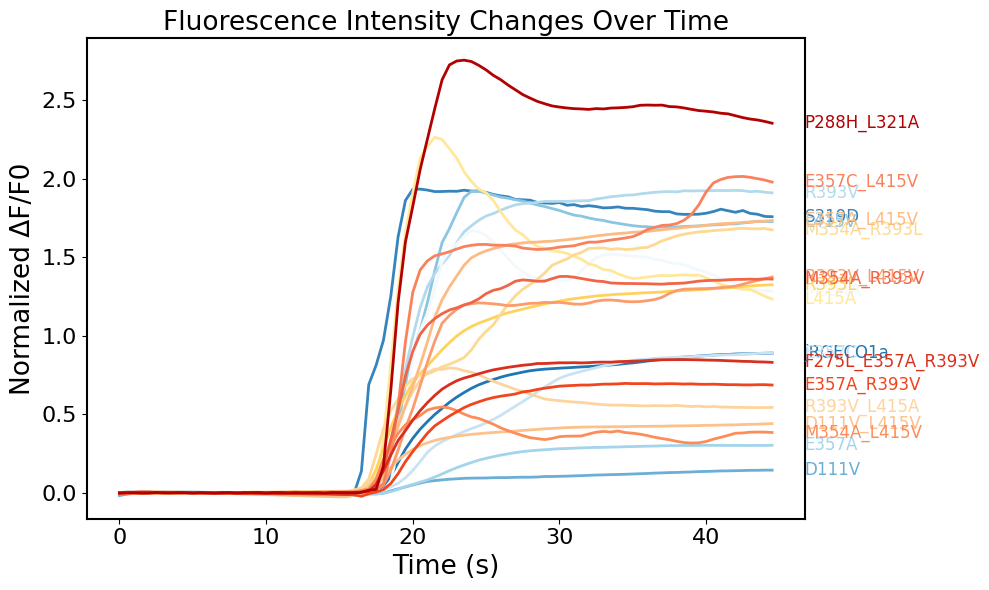

'E:/Synology_Backup/Imaging/2025_04_04_jRGECO1a_Double_Mutations/2025-04-04_CP_segementation_and_analysis/results\\Normalized_F-F0.pdf'

In [53]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

colors = ["#1F78B4", "#3684BC", "#6BAED6", "#8AC6E2", "#A2D4EB", "#B3DAEC", "#C9E3F3", "#F2F8FC", "#FFE79B", "#FFD25A", "#FDD991","#FDD49E", "#FDC18A","#FDBB84",  
          "#FC9B6B", "#FA815C","#FC8D59", "#F2451D", "#EF6548", "#D7301F", "#B30000"]

time_per_frame = 0.5

for i, (variant, data) in enumerate(results.items()):
    mean_dff = data["mean_dff"]
    sem_dff = data["sem_dff"]

    """plt.fill_between(
        range(len(mean_dff)), 
        mean_dff - sem_dff, 
        mean_dff + sem_dff, 
        color=colors[i], alpha=0.2
    )"""

    time_in_seconds = [frame * time_per_frame for frame in range(len(mean_dff))]

    plt.plot(time_in_seconds, mean_dff, color=colors[i], linewidth=2)
    plt.text(time_in_seconds[-1] * 1.05, mean_dff[-1], variant, color=colors[i], fontsize=12, verticalalignment='center')

plt.tick_params(axis='both', labelsize=16)
plt.xlabel("Time (s)", fontsize=19) 
plt.ylabel("Normalized ΔF/F0", fontsize=19)
plt.title("Fluorescence Intensity Changes Over Time", fontsize=19)

plt.tight_layout()

ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(1.5)

output_file = os.path.join(output_folder, "Normalized_F-F0.pdf")
plt.savefig(output_file, format='pdf')
plt.show()

output_file
